Тестовое задание

1. Изучите данные и модель из статьи [James Wallbridge. Transformers for limit order books, https://arxiv.org/pdf/2003.00130.pdf](https://arxiv.org/pdf/2003.00130.pdf)
2. Проведите свой эксперимент по описанной в статье методике, используя их код на github. 
3. Опишите, получилось ли достигнуть таких же результатов как в статье, если нет, то объясните, почему? Найдите недочеты в логике статьи.
4. Предложите свои идеи по улучшению обработки данных и структуре модели.
5. Реализуйте как минимум 1 свою идею по улучшению, сравните результаты. Подробно объясните полученные результаты.

В [репозитории автора ](https://github.com/jwallbridge/translob) содержатся, к сожалению, лишь фрагменты решения. Нет полной модели, только отдельные слои. Поэтому для нашего исследования за основу возьмём другой репозиторий, [https://github.com/simaki/translob](https://github.com/simaki/translob), который содержит полную реализацию модели из рассматриваемой статьи с использованием библиотеки `pytorch`. 

Из этой модели мы убираем финальный `softmax` так как используемая нами функция ошибки `CrossEntropyLoss` принимает на вход логиты.

In [4]:
import numpy as np
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
from translob.nn import TransLOB

# 1. Данные
В статье используется датасет [FI-2010](https://etsin.fairdata.fi/dataset/73eb48d7-4dbc-4a10-a52a-da745b47a649), включающий в себя данные по заявкам (limit order book (LOB), отечественные трейдеры обычно говорят "стакан заявок") за 10 дней по 5 акциям на Хельсинской фондовой бирже (Helsinki Stock Exchange). Данные включают по 10 заявок на покупку и продажу, цена и объем - итого 40 значений для каждого момента времени по одной акции.

Исходный набор данных включает данные с пред- и пост- торговых аукционов, а также данные без этих аукционов. В статье используются данные без аукционов.

Имеются различные варианты нормировки данных. В статье используется `z-score`: $\bar{x}_t=\frac{x_t - \bar{y}}{\sigma_{\bar{y}}}$, где $\bar{y}$ (соответственно $\sigma_{\bar{y}}$) - среднее (соответственно стандартное отклонение) данных предыдущего дня.

Помимо заявок, данные содержат целевую переменную - направление изменения средней цены за некоторое последующее число шагов. Если относительное изменение цены положительное и больше, чем $\alpha = 0.002$, то целевая переменная равна +1, если отрицательное и по модулю больше $0.002$ - то -1, иначе - целевая переменная равна 0.


Для наших целей удобно загрузить данные в виде готовой таблицы. Для этого воспользуемся готовым пакетом [fi2010](https://github.com/simaki/fi2010)

In [ ]:
from fi2010 import fetch_fi2010

dataframe = fetch_fi2010(normalization="zscore")

ModuleNotFoundError: No module named 'fi2010'

In [ ]:
dataframe.head()

,STOCK,DAY,PRICE_ASK_0,PRICE_ASK_1,PRICE_ASK_2,PRICE_ASK_3,PRICE_ASK_4,PRICE_ASK_5,PRICE_ASK_6,PRICE_ASK_7,...,VOLUME_BID_5,VOLUME_BID_6,VOLUME_BID_7,VOLUME_BID_8,VOLUME_BID_9,LABEL_1TICK,LABEL_2TICK,LABEL_3TICK,LABEL_5TICK,LABEL_10TICK
0,1,1,0.408275,0.409877,0.409493,0.409170,0.408796,0.409242,0.409436,0.408336,...,-0.784121,-0.718656,-0.573157,-0.521503,-0.464096,0,0,0,0,0
1,1,1,0.408275,0.410898,0.410513,0.410191,0.412876,0.412301,0.413513,0.415468,...,-0.758706,-0.737892,-0.569944,-0.518372,-0.465155,0,0,0,0,0
2,1,1,0.407254,0.406815,0.407452,0.408150,0.407776,0.407202,0.409436,0.408336,...,-0.758706,-0.737892,-0.569944,-0.518372,-0.465155,-1,-1,0,0,0
3,1,1,0.407254,0.408857,0.409493,0.409170,0.408796,0.411282,0.413513,0.415468,...,-0.784121,-0.718656,-0.573157,-0.521503,-0.464096,0,0,-1,0,0
4,1,1,0.407254,0.408857,0.409493,0.409170,0.408796,0.411282,0.413513,0.415468,...,-0.784121,-0.718656,-0.573157,-0.521503,-0.464096,1,1,1,0,0


In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284875 entries, 0 to 284874
Data columns (total 47 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   STOCK         284875 non-null  int64  
 1   DAY           284875 non-null  int64  
 2   PRICE_ASK_0   284875 non-null  float64
 3   PRICE_ASK_1   284875 non-null  float64
 4   PRICE_ASK_2   284875 non-null  float64
 5   PRICE_ASK_3   284875 non-null  float64
 6   PRICE_ASK_4   284875 non-null  float64
 7   PRICE_ASK_5   284875 non-null  float64
 8   PRICE_ASK_6   284875 non-null  float64
 9   PRICE_ASK_7   284875 non-null  float64
 10  PRICE_ASK_8   284875 non-null  float64
 11  PRICE_ASK_9   284875 non-null  float64
 12  PRICE_BID_0   284875 non-null  float64
 13  PRICE_BID_1   284875 non-null  float64
 14  PRICE_BID_2   284875 non-null  float64
 15  PRICE_BID_3   284875 non-null  float64
 16  PRICE_BID_4   284875 non-null  float64
 17  PRICE_BID_5   284875 non-null  float64
 18  PRIC

In [ ]:
dataframe.STOCK.unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [ ]:
dataframe.DAY.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

### датасет

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, dataframe, stock_idx=None):
        WINDOW = 100
        N_VARS = 40
        Y_LABEL = 'LABEL_10TICK'
        
        x_arrs = []
        y_arrs = []
        
        if stock_idx is None:
            stocks = sorted(dataframe.STOCK.unique())
        elif isinstance(stock_idx, list):
            stocks = stock_idx
        else:
            stocks = [stock_idx]
            
        for stock in stocks:
            for day in sorted(dataframe.DAY.unique()):
                stock_dataframe = dataframe[(dataframe.STOCK == stock) & (dataframe.DAY == day)]
                n = stock_dataframe.shape[0]
                x_stock = np.zeros((n - WINDOW + 1, N_VARS, WINDOW))
                y_stock = np.zeros(n - WINDOW + 1)
                for i in range(n - WINDOW + 1):
                    x_stock[i, :, :] = stock_dataframe.iloc[i:i + WINDOW, 2:2 + N_VARS].values.T
                    y_stock[i] = stock_dataframe[Y_LABEL].iloc[i + WINDOW - 1]
                x_arrs.append(x_stock)
                y_arrs.append(y_stock)
            
        self.x = torch.from_numpy(np.concatenate(x_arrs)).float()
        self.y = torch.from_numpy(np.concatenate(y_arrs) + 1).long()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i, :, :], self.y[i]

In [ ]:
batch_size = 32

dataset_train = Dataset(dataframe[dataframe['DAY'] <= 7])
dataset_test = Dataset(dataframe[dataframe['DAY'] > 7])

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
def build_model(train_loader, test_loader, n_epochs=50, lr=0.0001, print_acc=True, tf_dropout_rate=0.0):
    model = TransLOB(tf_dropout_rate=tf_dropout_rate)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    loss_fn = nn.CrossEntropyLoss()

    train_accs = []
    test_accs = []

    for i in range(n_epochs):
        model.train()
        n_correct = 0.
        n_total = 0.
        for x_train, y_train in train_loader:

            y_pred = model(x_train)

            loss = loss_fn(y_pred, y_train)

            optimizer.zero_grad()

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            _, predictions = torch.max(y_pred, 1)
            n_correct += (predictions == y_train).sum().item()
            n_total += y_train.shape[0]

        train_accuracy = n_correct / n_total
        train_accs.append(train_accuracy)

        model.eval()
        n_correct = 0.
        n_total = 0.
        for x_test, y_test in test_loader:
            y_pred = model(x_test)

            _, predictions = torch.max(y_pred, 1)

            n_correct += (predictions == y_test).sum().item()
            n_total += y_test.shape[0]

        test_accuracy = n_correct / n_total
        test_accs.append(test_accuracy)

        if print_acc:
            print(f"Epoch: {i + 1}, train acc: {train_accuracy:.4f}, test acc: {test_accuracy:.4f} ")
    return model, train_accs, test_accs

model, train_accs, test_accs = build_model(train_loader, test_loader)

Epoch: 1, train acc: 0.4249, test acc: 0.3653 
Epoch: 2, train acc: 0.4477, test acc: 0.4396 
Epoch: 3, train acc: 0.4807, test acc: 0.5040 
Epoch: 4, train acc: 0.5004, test acc: 0.5163 
Epoch: 5, train acc: 0.5436, test acc: 0.5725 
Epoch: 6, train acc: 0.5854, test acc: 0.5861 
Epoch: 7, train acc: 0.6061, test acc: 0.5797 
Epoch: 8, train acc: 0.6244, test acc: 0.6078 
Epoch: 9, train acc: 0.6399, test acc: 0.6082 
Epoch: 10, train acc: 0.6550, test acc: 0.6219 
Epoch: 11, train acc: 0.6656, test acc: 0.6141 
Epoch: 12, train acc: 0.6768, test acc: 0.6238 
Epoch: 13, train acc: 0.6847, test acc: 0.6134 
Epoch: 14, train acc: 0.6943, test acc: 0.6254 
Epoch: 15, train acc: 0.7020, test acc: 0.6178 
Epoch: 16, train acc: 0.7087, test acc: 0.6238 
Epoch: 17, train acc: 0.7162, test acc: 0.6225 
Epoch: 18, train acc: 0.7229, test acc: 0.6240 
Epoch: 19, train acc: 0.7303, test acc: 0.6139 
Epoch: 20, train acc: 0.7358, test acc: 0.6100 
Epoch: 21, train acc: 0.7413, test acc: 0.6219 
E

In [ ]:
def plot_progress(train_accs, test_accs, stock_idx=None):
    plt.plot(train_accs, label='train accuracy')
    plt.plot(test_accs, label='test accuracy')
    plt.plot(np.ones_like(train_accs), '--', label='100% accuracy')
    if stock_idx is None:
        plt.title(f'Accuracy', fontsize=14)
    else:
        plt.title(f'Accuracy, stock = {stock_idx}', fontsize=14)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

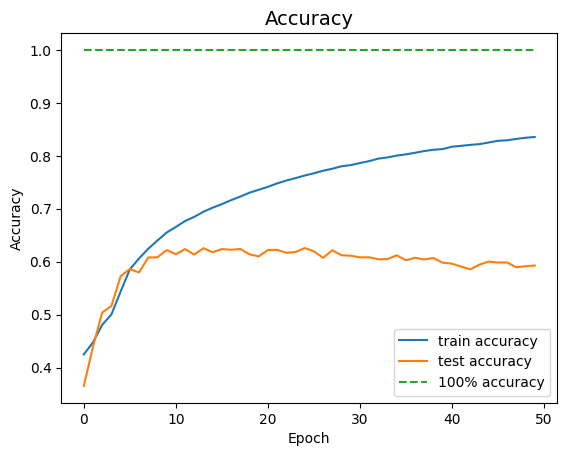

In [ ]:
plot_progress(train_accs, test_accs)

Попробуем ввести ненулевой дропаут в  трансформеры.

Epoch: 1, train acc: 0.4279, test acc: 0.3508 
Epoch: 2, train acc: 0.4440, test acc: 0.4220 
Epoch: 3, train acc: 0.4760, test acc: 0.4743 
Epoch: 4, train acc: 0.5192, test acc: 0.5348 
Epoch: 5, train acc: 0.5729, test acc: 0.5708 
Epoch: 6, train acc: 0.6024, test acc: 0.5862 
Epoch: 7, train acc: 0.6201, test acc: 0.6021 
Epoch: 8, train acc: 0.6365, test acc: 0.6080 
Epoch: 9, train acc: 0.6494, test acc: 0.6052 
Epoch: 10, train acc: 0.6599, test acc: 0.6071 
Epoch: 11, train acc: 0.6711, test acc: 0.6062 
Epoch: 12, train acc: 0.6794, test acc: 0.6104 
Epoch: 13, train acc: 0.6870, test acc: 0.6107 
Epoch: 14, train acc: 0.6940, test acc: 0.6125 
Epoch: 15, train acc: 0.7003, test acc: 0.6138 
Epoch: 16, train acc: 0.7067, test acc: 0.6057 
Epoch: 17, train acc: 0.7122, test acc: 0.6107 
Epoch: 18, train acc: 0.7174, test acc: 0.6036 
Epoch: 19, train acc: 0.7216, test acc: 0.6092 
Epoch: 20, train acc: 0.7252, test acc: 0.6053 
Epoch: 21, train acc: 0.7305, test acc: 0.6061 
E

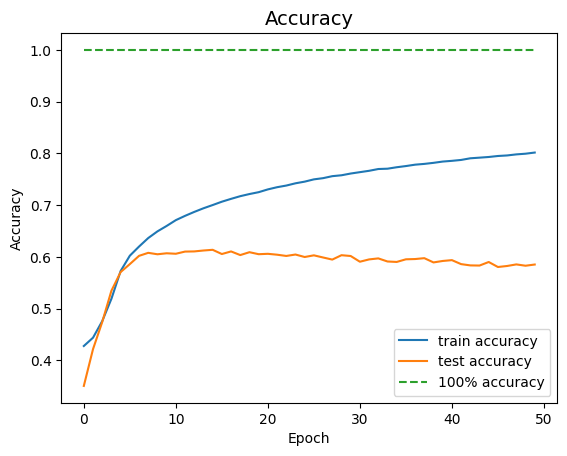

In [ ]:
model, train_accs, test_accs = build_model(train_loader, test_loader, tf_dropout_rate=0.5)
plot_progress(train_accs, test_accs)

__Выводы__
Проведённый эксперимент показывает максимальную точность 62% на тестовой выборке, в то время как в оригинальной статье говорится о точности 88%.

Попытка изменить модель путём дополнительных дропаутов в трансформерах ничего не меняет.

Причину расхождений установить невозможно, т.к. автор статьи опубликовал в своём репозитории лишь фрагменты модели; полного кода его вычислений у нас нет.

Обратим внимание на кривую обучения из оригинальной стати (`Figure 3: Training and validation accuracy for TransLOB for k = 100.`)

Мы видим, что у автора точность на валидации получаеться больше, чем точность на обучающей выборке. Это резко отличается от наших результатов. Конечно, нельзя исключить, что мы не правильно воспроизводим все идеи автора (или косяки перевода и понимания не дают таких же точностей, как в статье), однако, кривые обучения могут вести себя иначе: чаще всего точность на обучающей выборке выше, чем на выборке out-of-sample. Всё это позволяет выдвинуть предположение, что в авторской работе имеются проблемы с делением данных на обучающую / валидационную выборку.

Что можно сделать: 

1. Одна из идей для улучшения обработки данных в данном случае может быть использование нормализации данных на основе Z-оценки вместо нормализации на основе предыдущего дня среднего значения и стандартного отклонения. Это может помочь улучшить производительность модели и уменьшить влияние выбросов в данных.

Для использования Z-оценки для нормализации данных, вам потребуется:
+ Вычислить среднее значение и стандартное отклонение для каждого признака в данных.
+ Вычислить Z-оценку для каждого значения признака в данных, используя формулу Z = (x - mean) / std, где x - значение признака, mean - среднее значение признака, std - стандартное отклонение признака.
+ Использовать Z-оценку вместо исходного значения признака в модели.